In [1]:
# Вывести распределение (количество) клиентов по сферам деятельности, отсортировав результат по убыванию количества.
select 
    job_industry_category,
    count(job_industry_category) as количество
from customer 
group by job_industry_category
order by количество desc;

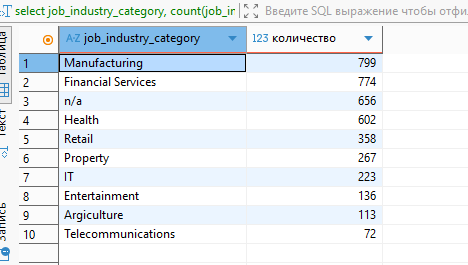

In [ ]:
# Найти общую сумму дохода (list_price*quantity) по всем подтвержденным заказам за каждый месяц по сферам деятельности клиентов. 
# Отсортировать результат по году, месяцу и сфере деятельности.
select
    c.job_industry_category,
    extract (year from o.order_date) as год,
    extract (month from o.order_date) as месяц,
    sum(oi.quantity*oi.item_list_price_at_sale) as сумма_дохода
from customer c 
join orders o on c.customer_id = o.customer_id
join order_items oi on o.order_id = oi.order_id
where o.order_status = 'Approved'
group by год, месяц, c.job_industry_category
order by год, месяц, job_industry_category asc;

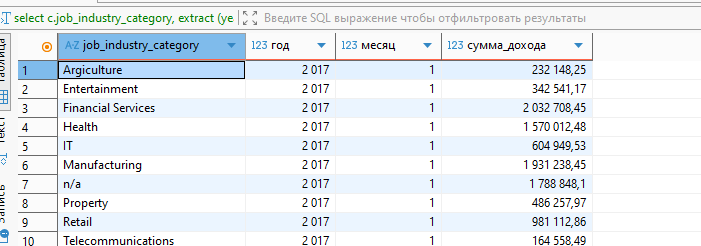

In [ ]:
# Вывести количество уникальных онлайн-заказов для всех брендов в рамках подтвержденных заказов клиентов из сферы IT. 
# Включить бренды, у которых нет онлайн-заказов от IT-клиентов, — для них должно быть указано количество 0.
select
    p.brand,
    count(distinct o.order_id) as количество
from product p 
join order_items oi on oi.product_id = p.product_id
join orders o on o.order_id = oi.order_id
join customer c on c.customer_id = o.customer_id
where c.job_industry_category = 'IT' and o.order_status = 'Approved' and o.online_order = True
group by p.brand

union

select
    p.brand,
    0 as количество
from product p
where p.brand not in (
    select distinct p2.brand
    from product p2 
    join order_items oi2 ON oi2.product_id = p2.product_id
    join orders o2 ON o2.order_id = oi2.order_id
    join customer c2 ON c2.customer_id = o2.customer_id
    where c2.job_industry_category = 'IT' and o2.order_status = 'Approved' and o2.online_order = True
)
group by p.brand
order by количество ASC, brand;

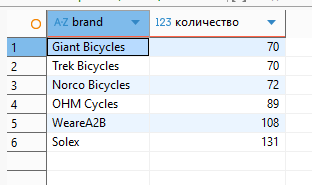

In [ ]:
# Найти по всем клиентам: сумму всех заказов (общего дохода), максимум, минимум и количество заказов, 
# а также среднюю сумму заказа по каждому клиенту. Отсортировать результат по убыванию суммы всех заказов и количества заказов. 


select
    c.customer_id,
    sum(oi.quantity*oi.item_list_price_at_sale) as сумма_дохода,
    max(oi.quantity*oi.item_list_price_at_sale) as макс_сумма,
    min(oi.quantity*oi.item_list_price_at_sale) as мин_сумма,
    count(*) as количество,
    avg(oi.quantity*oi.item_list_price_at_sale) as ср_сумма
from customer c
join orders o on c.customer_id = o.customer_id
join order_items oi on o.order_id = oi.order_id
group by c.customer_id
order by сумма_дохода desc, количество desc;


# Выполнить двумя способами: используя только GROUP BY и используя только оконные функции. Сравнить результат.
select
    c.customer_id,
    sum(oi.quantity*oi.item_list_price_at_sale) over(partition by c.customer_id) as сумма_дохода,
    max(oi.quantity*oi.item_list_price_at_sale) over(partition by c.customer_id) as макс_сумма,
    min(oi.quantity*oi.item_list_price_at_sale) over(partition by c.customer_id) as мин_сумма,
    count(*) over(partition by c.customer_id) as количество,
    avg(oi.quantity*oi.item_list_price_at_sale) over(partition by c.customer_id) as ср_сумма
from customer c
join orders o on c.customer_id = o.customer_id
join order_items oi on o.order_id = oi.order_id
order by сумма_дохода desc, количество desc;


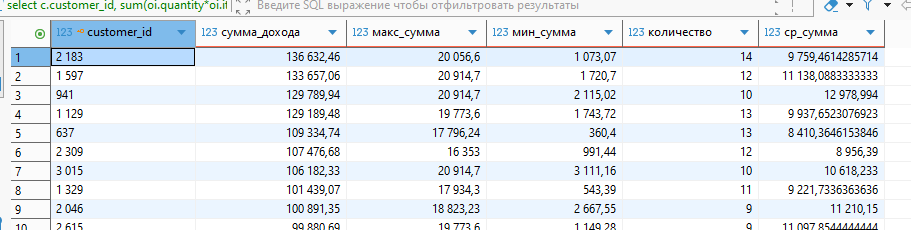
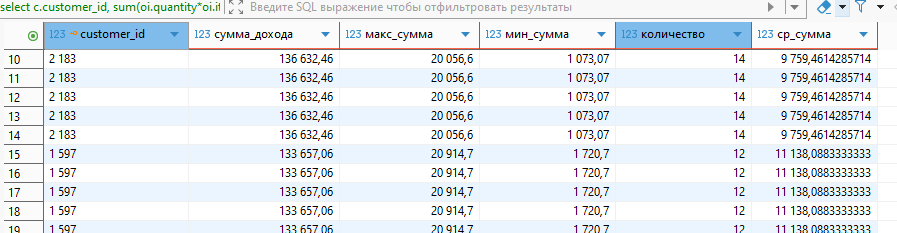

In [ ]:
# Найти имена и фамилии клиентов с топ-3 минимальной и топ-3 максимальной суммой транзакций за весь период 
# (учесть клиентов, у которых нет заказов, приняв их сумму транзакций за 0).
(select
    first_name,
    last_name,
    sum(quantity*item_list_price_at_sale) as стоимость_заказа
from customer c
join orders o on c.customer_id = o.customer_id
join order_items oi on o.order_id = oi.order_id
group by first_name, last_name
order by стоимость_заказа desc limit 3)

union

(select
    first_name,
    last_name,
    COALESCE(sum(quantity*item_list_price_at_sale),0) as стоимость_заказа
from customer c
left join orders o on c.customer_id = o.customer_id
left join order_items oi on o.order_id = oi.order_id
group by first_name, last_name
order by стоимость_заказа asc limit 3)
order by стоимость_заказа desc;

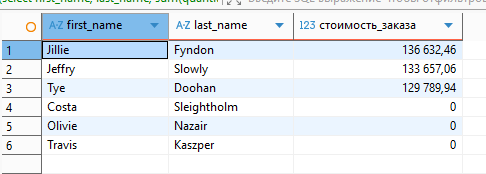

In [ ]:
# Вывести только вторые транзакции клиентов (если они есть) с помощью оконных функций. 
# Если у клиента меньше двух транзакций, он не должен попасть в результат.
select 
    customer_id,
    first_name,
    last_name,
    order_id,
    order_date
from (
    select 
        c.customer_id,
        c.first_name,
        c.last_name,
        o.order_id,
        o.order_date,
        row_number() over (partition by c.customer_id order by o.order_date) as порядковый_номер
    from customer c
    join orders o ON c.customer_id = o.customer_id) as table_number_row
where порядковый_номер = 2;

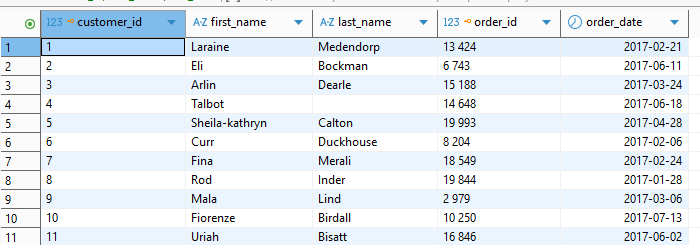

In [ ]:
# Вывести имена, фамилии и профессии клиентов, а также длительность максимального интервала (в днях) между двумя 
# последовательными заказами. Исключить клиентов, у которых только один или меньше заказов.
select 
    c.customer_id,
    c.first_name,
    c.last_name,
    c.job_title,
    max(interval_days) as макс_интервал
from (
     select 
        customer_id,
        lead(order_date) over(partition by customer_id order by order_date) - order_date as interval_days
    from orders
    where order_status = 'Approved'
) as intervals
join customer c ON intervals.customer_id = c.customer_id
where interval_days is not null
group by c.customer_id, c.first_name, c.last_name, c.job_title
order by макс_интервал desc;

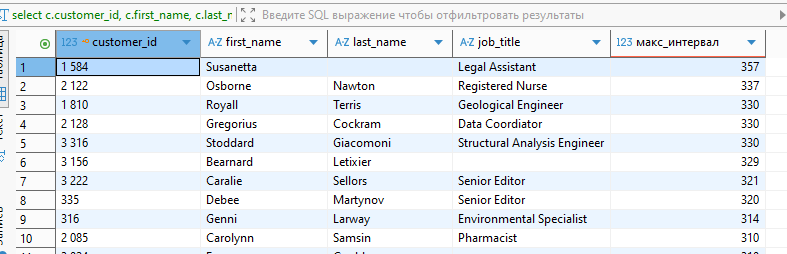

In [ ]:
# Найти топ-5 клиентов (по общему доходу) в каждом сегменте благосостояния (wealth_segment). 
# Вывести имя, фамилию, сегмент и общий доход. Если в сегменте менее 5 клиентов, вывести всех.
select
    first_name,
    last_name,
    wealth_segment as сегмент,
    общий_доход,
    место
from (
    select 
        c.first_name,
        c.last_name,
        c.wealth_segment,
        sum(oi.quantity*oi.item_list_price_at_sale) as общий_доход,
        row_number() over (partition by c.wealth_segment order by sum(oi.quantity*oi.item_list_price_at_sale) desc) as место
    from customer c
    join orders o on c.customer_id = o.customer_id
    join order_items oi on o.order_id = oi.order_id
    where o.order_status = 'Approved'
    group by c.customer_id, c.first_name, c.last_name, c.wealth_segment
) as ranked
where место <= 5
order by сегмент, место;

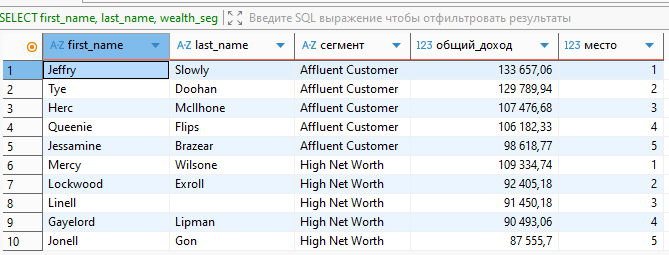